In [5]:
import os
import torch
import cv2
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [6]:
# Defining dataset directory
dataset_dir = "Micro_Organism"

### 3. Visualize/summarize the data (a-d)

In [7]:
# List of classes, filtering out .DS_Store
classes = [cls for cls in os.listdir(dataset_dir) if not cls.startswith('.')]

# Dictionary to store the count of images per class
class_counts = defaultdict(int)

# Dictionary to store at least 2 images per class
class_images = defaultdict(list)


# Loop through each class folder
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)
    class_counts[cls] = len(images)
    for i in range(2):
        image_path = os.path.join(class_dir, images[i])
        image = cv2.imread(image_path)
        class_images[cls].append(image)


# Calculating total number of entities (images) in the dataset
total_entities = sum(class_counts.values())

# Number of classes
num_classes = len(classes)

# Displaying summary
print("Summary:")
print("a. Number of entities in the dataset:", total_entities)
print("   Number of classes in the target variable:", num_classes)

Summary:
a. Number of entities in the dataset: 789
   Number of classes in the target variable: 8


b. Number of pixels in the image - Height: 320  Width: 480
c. Number of images per class:
    Amoeba : 72
    Euglena : 168
    Hydra : 76
    Paramecium : 152
    Rod_bacteria : 85
    Spherical_bacteria : 86
    Spiral_bacteria : 75
    Yeast : 75
d. Displaying at least 2 images of each class:


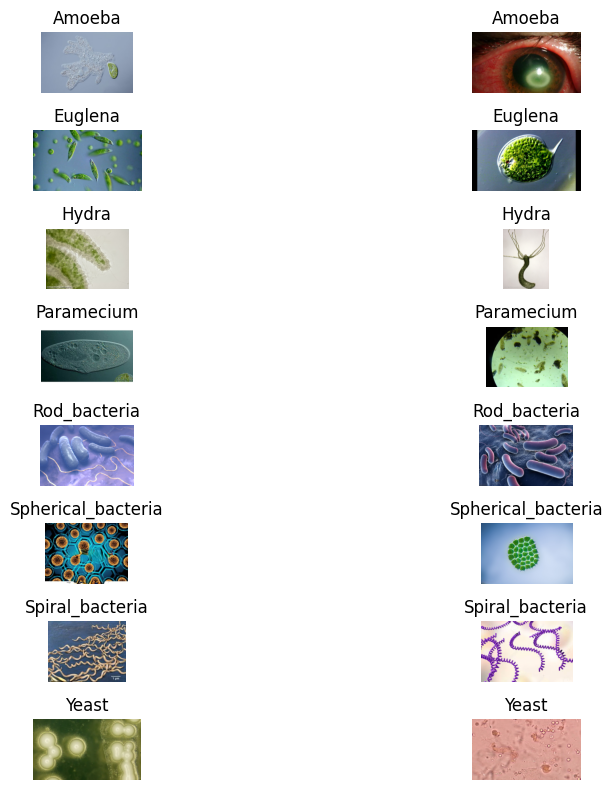

In [8]:
# Display number of pixels in the image (Height and Width)
image_height, image_width, _ = class_images[classes[0]][0].shape
print("b. Number of pixels in the image - Height:", image_height, " Width:", image_width)

print("c. Number of images per class:")
for cls, count in class_counts.items():
    print("   ", cls, ":", count)

# Display at least 2 images per class
print("d. Displaying at least 2 images of each class:")
plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    for j in range(2):
        plt.subplot(8, 2, i*2 + j + 1)
        plt.imshow(cv2.cvtColor(class_images[cls][j], cv2.COLOR_BGR2RGB))
        plt.title(cls)
        plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocessing

In [9]:
# Defining transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create dataset
dataset = ImageFolder(root=dataset_dir, transform=transform)


### Splitting

In [10]:
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Splitting dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Calculating the count of entities in the training set
train_entities_count = sum(len(dataset) for dataset in [train_dataset])
# Calculate the count of entities in the testing set
test_entities_count = sum(len(dataset) for dataset in [test_dataset])

# Displaying the count of entities in the training and testing sets
print("Count of entities in the training set:", train_entities_count)
print("Count of entities in the testing set:", test_entities_count)

Count of entities in the training set: 552
Count of entities in the testing set: 80


In [12]:
# Counting unique classes in a dataset
def count_unique_classes(dataset):
    classes_set = set()
    for sample in dataset:
        classes_set.add(sample[1])  # Assuming the class label is in the second position of each sample
    return len(classes_set)

# Counting unique classes in each set
train_classes_count = count_unique_classes(train_dataset)
val_classes_count = count_unique_classes(val_dataset)
test_classes_count = count_unique_classes(test_dataset)

# Displaying the number of classes in each set
print("Number of classes in the training set:", train_classes_count)
print("Number of classes in the validation set:", val_classes_count)
print("Number of classes in the testing set:", test_classes_count)


Number of classes in the training set: 8
Number of classes in the validation set: 8
Number of classes in the testing set: 8


### Modelling

In [7]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
class ReLUModel(BaseCNN):
    def __init__(self, num_classes):
        super(ReLUModel, self).__init__(num_classes)

class LeakyReLUModel(BaseCNN):
    def __init__(self, num_classes):
        super(LeakyReLUModel, self).__init__(num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(nn.functional.leaky_relu(self.conv2(x)))
        x = self.pool(nn.functional.leaky_relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ELUModel(BaseCNN):
    def __init__(self, num_classes):
        super(ELUModel, self).__init__(num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.elu(self.conv1(x)))
        x = self.pool(nn.functional.elu(self.conv2(x)))
        x = self.pool(nn.functional.elu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.elu(self.fc1(x))
        x = self.fc2(x)
        return x

class DropoutModel(BaseCNN):
    def __init__(self, num_classes):
        super(DropoutModel, self).__init__(num_classes)
        self.dropout = nn.Dropout(0.2)  # Adding dropout with 0.2 probability

    def forward(self, x):
        x = self.pool(nn.functional.tanh(self.conv1(x)))  # Using tanh activation function
        x = self.pool(nn.functional.tanh(self.conv2(x)))  # Using tanh activation function
        x = self.pool(nn.functional.tanh(self.conv3(x)))  # Using tanh activation function
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.tanh(self.fc1(x))  # Using tanh activation function
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

class NoDropoutModel(BaseCNN):
    def __init__(self, num_classes):
        super(NoDropoutModel, self).__init__(num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 4. Train a neural network 

In [9]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.train_f1_scores = []
        self.val_f1_scores = []

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            train_targets = []
            train_predictions = []

            for images, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                train_predictions.extend(predicted.tolist())
                train_targets.extend(labels.tolist())

            train_loss = running_loss / len(self.train_loader)
            train_f1 = f1_score(train_targets, train_predictions, average='weighted')
            self.train_f1_scores.append(train_f1)

            # Validation phase
            self.model.eval()
            val_targets = []
            val_predictions = []

            with torch.no_grad():
                for images, labels in self.val_loader:
                    outputs = self.model(images)
                    _, predicted = torch.max(outputs, 1)
                    val_predictions.extend(predicted.tolist())
                    val_targets.extend(labels.tolist())

            val_f1 = f1_score(val_targets, val_predictions, average='weighted')
            self.val_f1_scores.append(val_f1)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {train_loss}, Train F1-score: {train_f1}, Validation F1-score: {val_f1}")

        return self.train_f1_scores, self.val_f1_scores

    def evaluate(self, test_loader):
        self.model.eval()
        test_targets = []
        test_predictions = []

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                test_predictions.extend(predicted.tolist())
                test_targets.extend(labels.tolist())

        test_accuracy = accuracy_score(test_targets, test_predictions)
        test_f1_score = f1_score(test_targets, test_predictions, average='weighted')

        print(f"Testing Accuracy: {test_accuracy}")
        print(f"Testing F1-score: {test_f1_score}")



### b. Try out different activation functions
### c. Try with and without using dropout 
### d. Try different regularizations apart from dropout 
### e. Try different optimization algorithms 

In [10]:
# Instantiate models
relu_model = ReLUModel(num_classes=len(classes))
leaky_relu_model = LeakyReLUModel(num_classes=len(classes))
elu_model = ELUModel(num_classes=len(classes))
dropout_model = DropoutModel(num_classes=len(classes))
no_dropout_model = NoDropoutModel(num_classes=len(classes))

In [11]:
# Define loss function and optimizer for each model
criterion = nn.CrossEntropyLoss()
optimizer_relu = optim.Adam(relu_model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer_leaky_relu = optim.SGD(leaky_relu_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_elu = optim.Adam(elu_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_dropout = optim.Adagrad(dropout_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_no_dropout = optim.RMSprop(no_dropout_model.parameters(), lr=0.001, weight_decay=1e-3)

In [12]:
# Instantiate Trainer objects with respective models, loaders, criterion, and optimizers
trainer_relu = Trainer(relu_model, train_loader, val_loader, criterion, optimizer_relu)
trainer_leaky_relu = Trainer(leaky_relu_model, train_loader, val_loader, criterion, optimizer_leaky_relu)
trainer_elu = Trainer(elu_model, train_loader, val_loader, criterion, optimizer_elu)
trainer_dropout = Trainer(dropout_model, train_loader, val_loader, criterion, optimizer_dropout)
trainer_no_dropout = Trainer(no_dropout_model, train_loader, val_loader, criterion, optimizer_no_dropout)

In [13]:
# Define data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Train and evaluate each model
relu_train_f1_scores, relu_val_f1_scores = trainer_relu.train()
relu_test_f1_scores = trainer_relu.evaluate(test_loader)

Epoch 1/10, Loss: 2.5081759889920554, Train F1-score: 0.11815137325360976, Validation F1-score: 0.08170207089738887
Epoch 2/10, Loss: 2.0147950649261475, Train F1-score: 0.10259755944538552, Validation F1-score: 0.20028258766402363
Epoch 3/10, Loss: 1.9035963945918613, Train F1-score: 0.1913398894954366, Validation F1-score: 0.22302723463375215
Epoch 4/10, Loss: 1.7749193509419758, Train F1-score: 0.3192766529167323, Validation F1-score: 0.24145477864513895
Epoch 5/10, Loss: 1.6898479395442538, Train F1-score: 0.3548647561324304, Validation F1-score: 0.2882151240401451
Epoch 6/10, Loss: 1.5196034643385146, Train F1-score: 0.43040646694003765, Validation F1-score: 0.3232473251369218
Epoch 7/10, Loss: 1.3472941584057279, Train F1-score: 0.5320516086696337, Validation F1-score: 0.29582423287475884
Epoch 8/10, Loss: 1.0941138631767697, Train F1-score: 0.6279632433364206, Validation F1-score: 0.32987964364593353
Epoch 9/10, Loss: 0.9254552887545692, Train F1-score: 0.6918882236617195, Valid

### f. Create a graph of f1 score vs epochs for training and validation set.

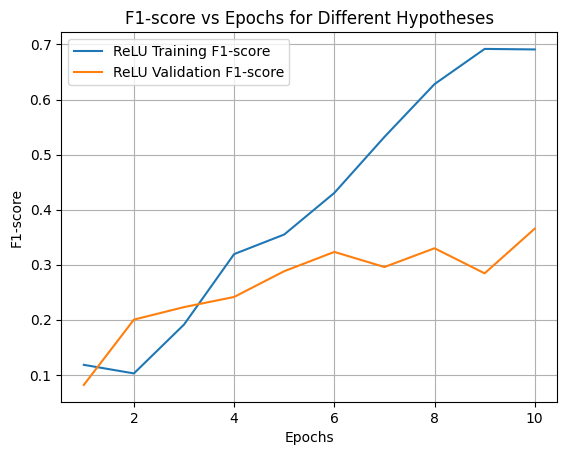

In [15]:
# Plotting F1-score for each epoch for ReLU model
epochs_relu = np.arange(1, trainer_relu.num_epochs + 1)
plt.plot(epochs_relu, relu_train_f1_scores, label='ReLU Training F1-score')
plt.plot(epochs_relu, relu_val_f1_scores, label='ReLU Validation F1-score')

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score vs Epochs for Different Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
leaky_relu_train_f1_scores, leaky_relu_val_f1_scores = trainer_leaky_relu.train()
leaky_relu_test_f1_scores = trainer_leaky_relu.evaluate(test_loader)

Epoch 1/10, Loss: 2.0694907108942666, Train F1-score: 0.0873040698557434, Validation F1-score: 0.08127653927813164
Epoch 2/10, Loss: 2.057536906666226, Train F1-score: 0.06359753992456046, Validation F1-score: 0.08127653927813164
Epoch 3/10, Loss: 2.0518641339408026, Train F1-score: 0.06709016298240092, Validation F1-score: 0.10603295216101115
Epoch 4/10, Loss: 2.046925703684489, Train F1-score: 0.10048437870628973, Validation F1-score: 0.11412516015441643
Epoch 5/10, Loss: 2.043945723109775, Train F1-score: 0.08356093305084109, Validation F1-score: 0.13975933177250002
Epoch 6/10, Loss: 2.0351293153233, Train F1-score: 0.11979898327561209, Validation F1-score: 0.14042095149983985
Epoch 7/10, Loss: 2.03348571062088, Train F1-score: 0.12043326649788584, Validation F1-score: 0.13221571288466336
Epoch 8/10, Loss: 2.034138626522488, Train F1-score: 0.13399531741789042, Validation F1-score: 0.13283248952038762
Epoch 9/10, Loss: 2.0308207472165427, Train F1-score: 0.13819257772762536, Validat

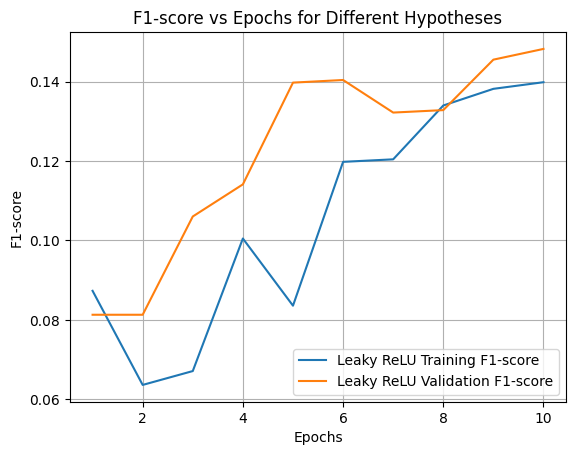

In [17]:
# Plotting F1-score for each epoch for Leaky ReLU model
epochs_leaky_relu = np.arange(1, trainer_leaky_relu.num_epochs + 1)
plt.plot(epochs_leaky_relu, leaky_relu_train_f1_scores, label='Leaky ReLU Training F1-score')
plt.plot(epochs_leaky_relu, leaky_relu_val_f1_scores, label='Leaky ReLU Validation F1-score')

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score vs Epochs for Different Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
elu_train_f1_scores, elu_val_f1_scores = trainer_elu.train()
elu_test_f1_scores = trainer_elu.evaluate(test_loader)

Epoch 1/10, Loss: 3.428506804837121, Train F1-score: 0.18645701399524056, Validation F1-score: 0.1649998928326116
Epoch 2/10, Loss: 1.9905680219332378, Train F1-score: 0.21914134374651734, Validation F1-score: 0.18081801167089345
Epoch 3/10, Loss: 1.770166602399614, Train F1-score: 0.3023414056120616, Validation F1-score: 0.25652723756511375
Epoch 4/10, Loss: 1.555403729279836, Train F1-score: 0.398151743846517, Validation F1-score: 0.28325020421580827
Epoch 5/10, Loss: 1.384589672088623, Train F1-score: 0.4870525440407377, Validation F1-score: 0.2850048086381083
Epoch 6/10, Loss: 1.189407421482934, Train F1-score: 0.5779579161076098, Validation F1-score: 0.23576202595436482
Epoch 7/10, Loss: 0.9631418916914198, Train F1-score: 0.6466675949733535, Validation F1-score: 0.28845689675258795
Epoch 8/10, Loss: 0.7762265652418137, Train F1-score: 0.7149089354508655, Validation F1-score: 0.3636450367928745
Epoch 9/10, Loss: 0.5025427614649137, Train F1-score: 0.8590922071609398, Validation F1

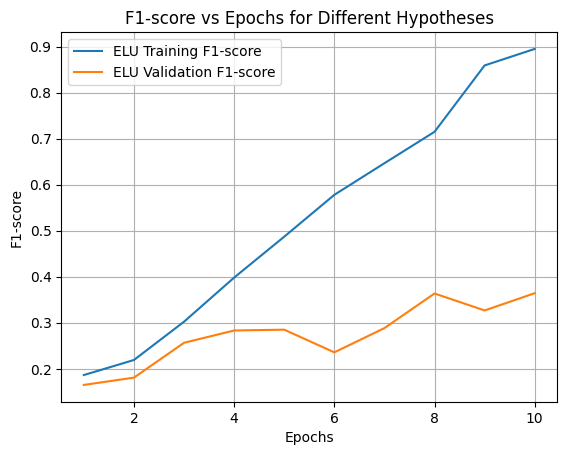

In [19]:
# Plotting F1-score for each epoch for ELU model
epochs_elu = np.arange(1, trainer_elu.num_epochs + 1)
plt.plot(epochs_elu, elu_train_f1_scores, label='ELU Training F1-score')
plt.plot(epochs_elu, elu_val_f1_scores, label='ELU Validation F1-score')

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score vs Epochs for Different Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
dropout_train_f1_scores, dropout_val_f1_scores = trainer_dropout.train()
dropout_test_f1_scores = trainer_dropout.evaluate(test_loader)

Epoch 1/10, Loss: 2.5087161461512246, Train F1-score: 0.20476658777530327, Validation F1-score: 0.16826712844874775
Epoch 2/10, Loss: 1.694260345564948, Train F1-score: 0.33791786462012363, Validation F1-score: 0.2476114960511641
Epoch 3/10, Loss: 1.4812734060817294, Train F1-score: 0.4935145008990288, Validation F1-score: 0.20920775729377605
Epoch 4/10, Loss: 1.3452714482943218, Train F1-score: 0.5407160037275924, Validation F1-score: 0.27837395944237947
Epoch 5/10, Loss: 1.1931607458326552, Train F1-score: 0.6181032733248072, Validation F1-score: 0.2626781398448431
Epoch 6/10, Loss: 1.0828031533294253, Train F1-score: 0.6610514706535372, Validation F1-score: 0.2729686226886491
Epoch 7/10, Loss: 0.9727242158518897, Train F1-score: 0.725206914954364, Validation F1-score: 0.25439207285773097
Epoch 8/10, Loss: 0.8822888599501716, Train F1-score: 0.7369691806887457, Validation F1-score: 0.28709973242197306
Epoch 9/10, Loss: 0.784363329410553, Train F1-score: 0.7915646849444433, Validation

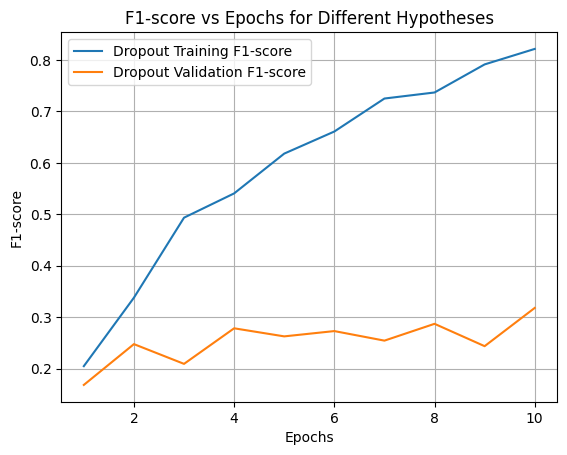

In [21]:
# Plotting F1-score for each epoch for Dropout model
epochs_dropout = np.arange(1, trainer_dropout.num_epochs + 1)
plt.plot(epochs_dropout, dropout_train_f1_scores, label='Dropout Training F1-score')
plt.plot(epochs_dropout, dropout_val_f1_scores, label='Dropout Validation F1-score')

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score vs Epochs for Different Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
no_dropout_train_f1_scores, no_dropout_val_f1_scores = trainer_no_dropout.train()
no_dropout_test_f1_scores = trainer_no_dropout.evaluate(test_loader)

Epoch 1/10, Loss: 15.56560421652264, Train F1-score: 0.13388030021738037, Validation F1-score: 0.08127653927813164
Epoch 2/10, Loss: 2.0250771840413413, Train F1-score: 0.11368945909635435, Validation F1-score: 0.10661765879667322
Epoch 3/10, Loss: 2.012131306860182, Train F1-score: 0.13137430780521564, Validation F1-score: 0.0826974259488439
Epoch 4/10, Loss: 1.9283125466770596, Train F1-score: 0.17981597494238435, Validation F1-score: 0.19292028565913916
Epoch 5/10, Loss: 1.8016159733136494, Train F1-score: 0.2692709155973687, Validation F1-score: 0.236045907383487
Epoch 6/10, Loss: 1.6619981659783258, Train F1-score: 0.3961860152768749, Validation F1-score: 0.1885762427163701
Epoch 7/10, Loss: 1.5556697580549452, Train F1-score: 0.4265048217136353, Validation F1-score: 0.233737063417855
Epoch 8/10, Loss: 1.300975779692332, Train F1-score: 0.5222336465333994, Validation F1-score: 0.22128088618774833
Epoch 9/10, Loss: 1.0884348418977525, Train F1-score: 0.6433132315907343, Validation 

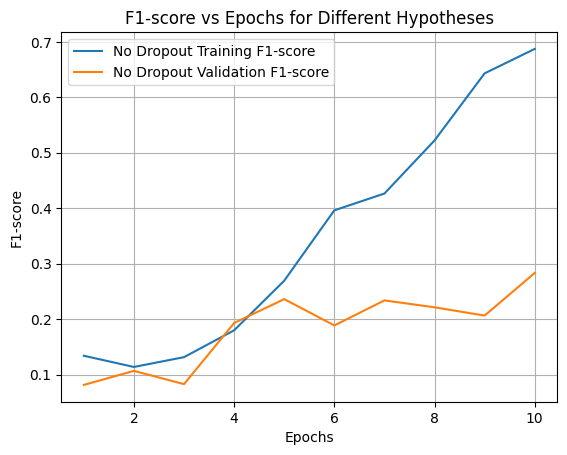

In [23]:
# Plotting F1-score for each epoch for No Dropout model
epochs_no_dropout = np.arange(1, trainer_no_dropout.num_epochs + 1)
plt.plot(epochs_no_dropout, no_dropout_train_f1_scores, label='No Dropout Training F1-score')
plt.plot(epochs_no_dropout, no_dropout_val_f1_scores, label='No Dropout Validation F1-score')

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score vs Epochs for Different Hypotheses')
plt.legend()
plt.grid(True)
plt.show()

### Count the total number of params in the final model

In [26]:
# Calculate the total number of parameters in the ELU model
total_params = sum(p.numel() for p in dropout_model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters in Final Model: {total_params}")


Total Trainable Parameters in Final Model: 25718312
